In [1]:
%matplotlib inline

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.0+cu116
0.13.0+cu116


In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

## Resampling Overview 

To resample an audio waveform from one frequency to another, Resampling Overview
To resample an audio waveform from one freqeuncy to another, you can use `torchaudio.transforms.Resample()` or `torchaudio.functional.resample()`. transforms.Resample precomputes and caches the kernel used for resampling, while functional.resample computes it on the fly, so using torchaudio.transforms.Resample will result in a speedup when resampling multiple waveforms using the same parameters (see Benchmarking section).

Both resampling methods use bandlimited sinc interpolation to compute signal values at arbitrary time steps. The implementation involves convolution, so we can take advantage of GPU / multithreading for performance improvements.

Because a finite number of samples can only represent a finite number of frequencies, resampling does not produce perfect results, and a variety of parameters can be used to control for its quality and computational speed. We demonstrate these properties through resampling a logarithmic sine sweep, which is a sine wave that increases exponentially in frequency over time.

The spectrograms below show the frequency representation of the signal, where the x-axis corresponds to the frequency of the original waveform (in log scale), y-axis the frequency of the plotted waveform, and color intensity the amplitude.

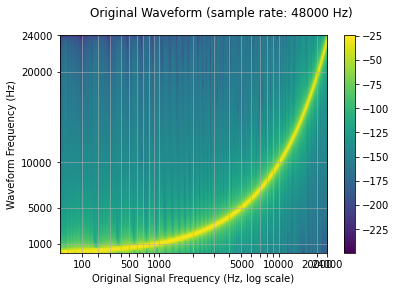

In [4]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

## Controlling resampling quality with parameters:

### Lowpass filter width
Because the filter used for interpolation extends infinitely, the `lowpass_filter_width` parameter is used to control for the width of the filter to use window the interpolation. It's also referred to as the number of zero crossing,since the interpolation passes through zero at every time unit using a larger `lowpass_filter_width` provides a sharper, more precise filter, but is more computationally expensive.

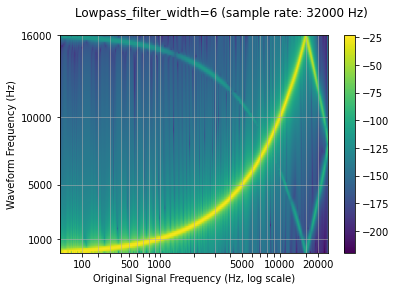

In [5]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="Lowpass_filter_width=6")

In [6]:
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

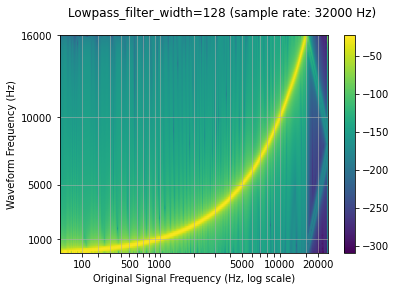

In [7]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="Lowpass_filter_width=128")
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

## Rolloff
The `rolloff` parameter is represented as a function of the Nyquist frequency, which is the maximal frequency representable by a given finite sample rate. `rolloff` determines the lowpass filter cutoff and controls the degree of aliasing, which takes place when frequencies higher than the Nyquist are mapped to lower frequencies. A lower rolloff will therefore reduce the amount of aliasing, but it will also reduce some of the higher frequencies. 

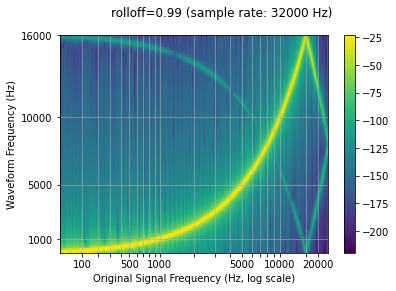

In [8]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title='rolloff=0.99')
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

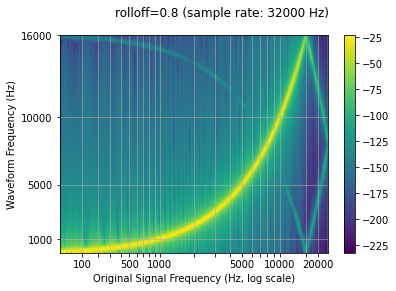

In [9]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title='rolloff=0.8')
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

## Window Function 
By default, torchaudio's resample uses the Hann window filter, which is a weighted cosine function. It additionally supports the Kaiser window, which is a near optimal window function that contains an additional `beta` parameter that allows for the design of the smoothness of the filter and width of impulse.
This can be controlled using the `resampling_method` parameter.


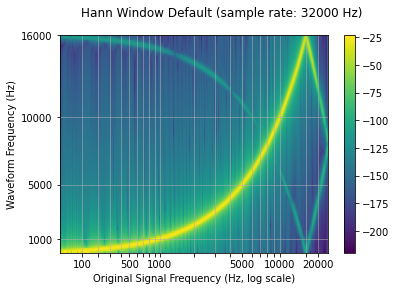

In [10]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title='Hann Window Default')
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

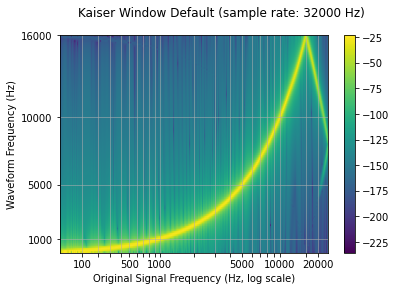

In [11]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title='Kaiser Window Default')
Audio(resampled_waveform.numpy()[0], rate=sample_rate)

a larger `lowpass_filter_width` results in a larger resampling kernel, and therefore increases computation time for both the kernel cpomputation and convolution. 